<a href="https://colab.research.google.com/github/manjiridatar/Transfer-Learning-with-TensorFlow-Cats-and-Dogs/blob/main/Transfer_Learning_TensorFlow_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning using pretrained MobileNetV2 and TensorFlow 2 - The Dogs vs Cats dataset

Our goal is to classify images of cat and dogs using the principle of transfer learning from a pre-trained model (in this case we will use MobileNetV2 which is pretrained on ImageNet dataset containing 1.4 million images and 1000 classes) using tensorflow's functional API. The lower layers of the pre-trained model contained generic features learned that can be applied to a specific task.

We will use the [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data), which was used for a 2013 Kaggle competition. It consists of 25000 images containing either a cat or a dog. We will only use a subset of 600 images and labels. The dataset is a subset of a much larger dataset of 3 million photos that were originally used as a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart), referred to as “Asirra” or Animal Species Image Recognition for Restricting Access.

J. Elson, J. Douceur, J. Howell, and J. Saul. "Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization." Proceedings of 14th ACM Conference on Computer and Communications Security (CCS), October 2007.

#### Import required modules and mount the drive

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, Softmax, Conv2D, Dropout, BatchNormalization, RandomFlip, RandomRotation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
%matplotlib inline


In [2]:
print(tf.__version__)

2.8.2


Lets mount the google drive since I'm running this in colab. If you are running this locally you may update the path

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import the data
The training, validation and testing datasets required for this project can be downloaded from the following links:

images_train: https://drive.google.com/open?id=1r0G39tYaSe7fObGIw6vlxUhv-HkENu4W

images_valid: https://drive.google.com/open?id=1_eMoeMi4KjTbcZpBr1Elz8gNU5SNIyiD

images_test: https://drive.google.com/open?id=1yLGqMixFsqzVznWU8rWrJ9ZHjVDIDTxG

labels_train: https://drive.google.com/open?id=1BEIuwRmS3Md1FgtdW6_45xiH-ysOWjV4

labels_valid: https://drive.google.com/open?id=19SS_jVTPqISO36R6Gia58MSAxAOT4-a8

labels_test: https://drive.google.com/open?id=1KGBMlxxA7b6m2rOIIM3DH2462ZUsP96z

You will need to store these files in the google drive that you previously mounted, for use in this Colab notebook.

In [4]:
images_train = np.load('/content/gdrive/MyDrive/data/images_train.npy') / 255.
images_valid = np.load('/content/gdrive/MyDrive/data/images_valid.npy') / 255.
images_test = np.load('/content/gdrive/MyDrive/data/images_test.npy') / 255.

labels_train = np.load('/content/gdrive/MyDrive/data/labels_train.npy')
labels_valid = np.load('/content/gdrive/MyDrive/data/labels_valid.npy')
labels_test = np.load('/content/gdrive/MyDrive/data/labels_test.npy')

### Examine the data

There are 600 training, 300 validation and 300 test images 

In [5]:
print("{} Training Images, shape {} ;" .format(images_train.shape[0], images_train.shape), "{} Training Labels, shape {}" .format(labels_train.shape[0], labels_train.shape))
print("{} Valdiation Images, shape {} ;" .format(images_valid.shape[0], images_valid.shape), "{} Validation Labels, shape {}" .format(labels_valid.shape[0], labels_valid.shape))
print("{} Test Images, shape {} ;" .format(images_test.shape[0], images_test.shape), "{} Test Labels, shape {}" .format(labels_test.shape[0], labels_test.shape))


600 Training Images, shape (600, 160, 160, 3) ; 600 Training Labels, shape (600,)
300 Valdiation Images, shape (300, 160, 160, 3) ; 300 Validation Labels, shape (300,)
300 Test Images, shape (300, 160, 160, 3) ; 300 Test Labels, shape (300,)


In [6]:
np.unique(labels_train)
np.unique(labels_valid)
np.unique(labels_test)

array([0, 1], dtype=int32)

In [7]:
labels_test[0:5]

array([1, 0, 0, 1, 0], dtype=int32)

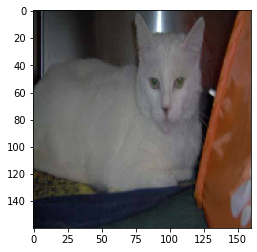

In [8]:
plt.imshow(images_test[3])


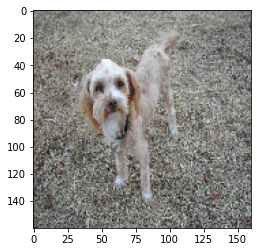

In [9]:
plt.imshow(images_test[1])

**Create class names since for predictions and visualizations later**

In [10]:
class_names = np.array(['Dog', 'Cat'])

**Examine randomly selected images/label pairs fron the training dataset**

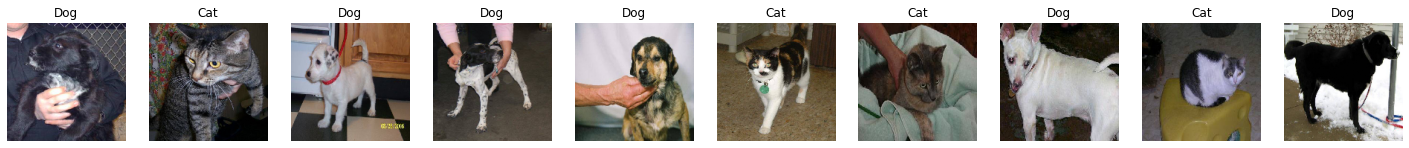

In [11]:
figure, axe = plt.subplots(1,10, figsize = (25,25))
axe.shape
for i in range(0,10):
  random_inx = np.random.choice(images_train.shape[0])
  axe[i].axis('off')
  axe[i].imshow (images_train[random_inx])
  axe[i].set_title(class_names[labels_train[random_inx]])

### Define constants


In [15]:
learning_rate = 0.0001
learning_rate_fine = 0.00001

epochs = 10
epochs_total = 20

batch_size = 32

reduce_lr_factor = 0.2
reduce_lr_factor_fine = 0.2

IMG_SHAPE = images_train[0].shape

### Create a benchmark CNN model 

We create, train a benchmark model for the purpose of comparing our transfer learning model later. We will be using the functional API, to build the benchmark model. We also use data augumentation layers such as RandomFlip and RandomRotation.


In [13]:
# Create a benchmark Model to compare to later on with our Transfer Learning Model

def get_benchmark_model(input_shape):
  inputs = tf.keras.Input(shape = input_shape)
  h = RandomFlip('horizontal_and_vertical')(inputs)
  h = RandomRotation(0.2)(h)
  h = Conv2D(32, kernel_size=(3,3), activation = 'relu', padding = 'SAME', name = 'Conv2D_1')(h)
  h = MaxPooling2D(pool_size=(2,2), name = 'MaxPool2D_1')(h)
  h = BatchNormalization()(h)
  h = Conv2D(64, kernel_size=(2,2), activation = 'relu', padding = 'SAME', name = 'Conv2D_2')(h)
  h = BatchNormalization()(h)
  h = Conv2D(64, kernel_size=(2,2), activation = 'relu', padding = 'SAME', name = 'Conv2D_3')(h)
  h = MaxPooling2D(pool_size = (2,2), name = 'MaxPool2D_2')(h)
  h = BatchNormalization()(h)
  h = Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'SAME', name = 'Conv2D_4')(h)
  h = Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'SAME', name = 'Conv2D_5')(h)
  h = BatchNormalization()(h)
  h = MaxPooling2D(pool_size = (2,2), name = 'MaxPool2D_3')(h)
  h = Flatten()(h)
  h = Dense(128, activation = 'relu', name = 'Dense_1')(h)
  outputs = Dense(1, activation = 'sigmoid', name = 'Dense_2')(h)

  model = Model(inputs = inputs, outputs = outputs)
  return model


In [14]:
benchmark_model = get_benchmark_model(images_train[0].shape)
benchmark_model.compile(optimizer = RMSprop(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])

**Benchmark Model Summary = Model has over 6 million trainable parameters**

In [16]:
benchmark_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 160, 160, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 160, 160, 3)      0         
 tion)                                                           
                                                                 
 Conv2D_1 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 MaxPool2D_1 (MaxPooling2D)  (None, 80, 80, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 80, 80, 32)       128       
 ormalization)                                               

**Train the benchmark model on the training dataset**

In [17]:
# early_stopping = EarlyStopping(patience = 3)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor = 'val_loss', factor = reduce_lr_factor, patience = 2, verbose = 1)
reduce_lr_on_plateau_fine = ReduceLROnPlateau(monitor = 'val_loss', factor = reduce_lr_factor_fine, patience = 2, verbose = 1)

In [18]:
history_benchmark = benchmark_model.fit(images_train, labels_train, epochs = 10, batch_size=batch_size,
                                        validation_data = (images_valid, labels_valid),
                                        callbacks = [reduce_lr_on_plateau])


Epoch 1/10
19/19 [==============================] - 70s 4s/step - loss: 1.5604 - accuracy: 0.5217 - val_loss: 0.7113 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/10
19/19 [==============================] - 62s 3s/step - loss: 0.7048 - accuracy: 0.6067 - val_loss: 0.8056 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.6350
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
19/19 [==============================] - 63s 3s/step - loss: 0.6644 - accuracy: 0.6350 - val_loss: 0.9418 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/10
19/19 [==============================] - 61s 3s/step - loss: 0.5956 - accuracy: 0.6900 - val_loss: 1.0144 - val_accuracy: 0.5000 - lr: 2.0000e-05
Epoch 5/10
19/19 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.6783
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
19/19 [==============================] - 6

**Plot the accuracy and loss curves for the benchmark model**


No handles with labels found to put in legend.
No handles with labels found to put in legend.


<function matplotlib.pyplot.show>

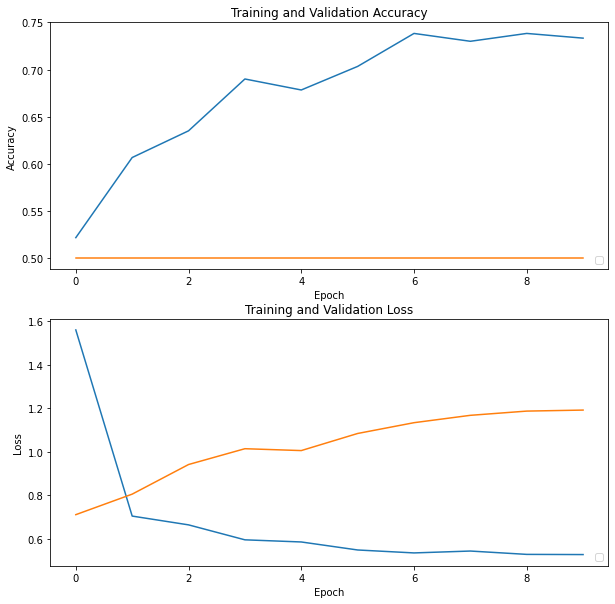

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(history_benchmark.history['accuracy'])
plt.plot(history_benchmark.history['val_accuracy'])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.show


plt.subplot(2,1,2)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show

**Evaluate the performance of the benchmark model. Looks like an over fit! It's not doing well on unseen data that was not used for training**

In [20]:
benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(benchmark_test_loss))
print("Test accuracy: {}".format(benchmark_test_acc))

Test loss: 1.1606570482254028
Test accuracy: 0.5


### Load the pretained MobileNetV2 Model without the top layer.

We now load the pretrained model MobileNetV2 without the topmost layer and examine it's summary. This model has over 2.2 million trainable parameters.

In [21]:
base_model = MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')

In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Build a customized modeling using the base MobileNetV2 model

We now build a customized model to add a classification head to the base model by adding an averagepooling layer and a prediction layer (Dense) with 1 node and activation = 'sigmoid'. Upon examining the summary we see that there are still over 2.2 million trainable parameters. 

After building the model, we will then be freezing all the layers of the pretrained model and training our customized model on our dataset

In [23]:
def get_transfer_learning_model(input_shape):
  
  inputs = Input(input_shape)
  h = RandomFlip('horizontal_and_vertical')(inputs)
  h = RandomRotation(0.2)(h)
  h = base_model(h, training=False)
  h = GlobalAveragePooling2D()(h)
  h = Dense(32, activation = 'relu') (h)
  h = Dropout(0.2)(h)
  outputs = Dense(1, activation = 'sigmoid')(h)

  model = Model(inputs = inputs, outputs = outputs)
  return model


In [24]:
transferLearn_model = get_transfer_learning_model(IMG_SHAPE)
transferLearn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 160, 160, 3)      0         
 tation)                                                         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                           

**Set base model layer trainable as False. Notice in the summary now only about 41K parameters are trainable**


In [25]:
transferLearn_model.layers[3].trainable = False
transferLearn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 160, 160, 3)      0         
 tation)                                                         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                           

In [26]:
transferLearn_model.compile(optimizer = RMSprop(learning_rate=learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])

**Train the customized model with the pretrained model frozen**

In [27]:
history_transferLearn = transferLearn_model.fit(images_train, labels_train, epochs = 10, batch_size = 32,
                                                validation_data = (images_valid, labels_valid),
                                                callbacks = [reduce_lr_on_plateau])

Epoch 1/10
19/19 [==============================] - 17s 755ms/step - loss: 0.7122 - accuracy: 0.5983 - val_loss: 0.5040 - val_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 2/10
19/19 [==============================] - 13s 698ms/step - loss: 0.5765 - accuracy: 0.7033 - val_loss: 0.4010 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 3/10
19/19 [==============================] - 13s 697ms/step - loss: 0.5273 - accuracy: 0.7317 - val_loss: 0.3371 - val_accuracy: 0.9267 - lr: 1.0000e-04
Epoch 4/10
19/19 [==============================] - 13s 698ms/step - loss: 0.4634 - accuracy: 0.7967 - val_loss: 0.2808 - val_accuracy: 0.9367 - lr: 1.0000e-04
Epoch 5/10
19/19 [==============================] - 13s 698ms/step - loss: 0.4146 - accuracy: 0.8200 - val_loss: 0.2460 - val_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 6/10
19/19 [==============================] - 13s 699ms/step - loss: 0.4033 - accuracy: 0.8100 - val_loss: 0.2237 - val_accuracy: 0.9367 - lr: 1.0000e-04
Epoch 7/10
19/19 [======================

**Plot the accuracy and loss of the customized model that has now been trained on our cats and dogs dataset**

<function matplotlib.pyplot.show>

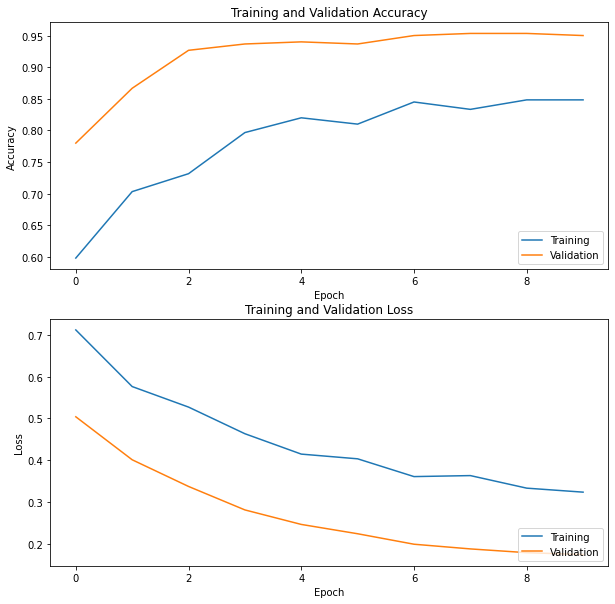

In [28]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(history_transferLearn.history['accuracy'])
plt.plot(history_transferLearn.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(history_transferLearn.history['loss'])
plt.plot(history_transferLearn.history['val_loss'])
plt.legend(['Training', 'Validation'],loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show

**Evaluate perfoamnce of the customized model that has tranfer learned from the mobileNetV2 model. This looks like a significant improvement compared to the benchmark model**

We see that the accuracy has significantly improved

In [29]:
transferLearn_test_loss, transferLearn_test_acc = transferLearn_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(transferLearn_test_loss))
print("Test accuracy: {}".format(transferLearn_test_acc))

Test loss: 0.1574895679950714
Test accuracy: 0.9566666483879089


### Compare the benchmark model vs our customized tranfer learn model
Plot the confusion matrices and the performance matrices for both models. We see that the customized model is doing significantly better in comparison

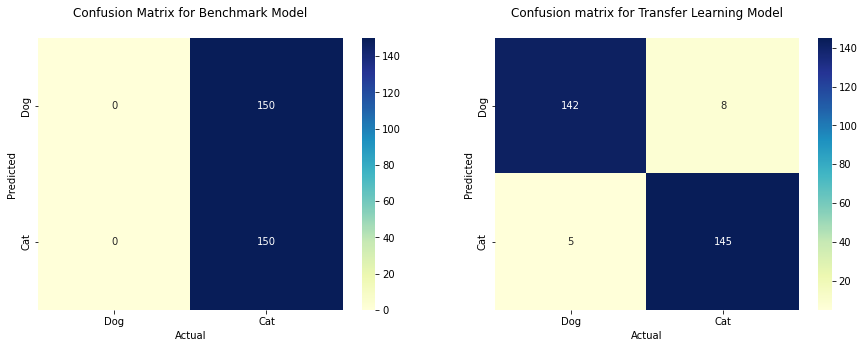

In [30]:
plt.figure(figsize = (15,5))

predictions_bnch = benchmark_model.predict(images_test)
predictions_bnch = (predictions_bnch >= 0.5).astype(np.int32)

confusion_mtx_bnch = confusion_matrix(labels_test, predictions_bnch)
df_confusion_mtx_bnch = pd.DataFrame(confusion_mtx_bnch, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])

plt.subplot(121)
plt.title("Confusion Matrix for Benchmark Model\n")
sns.heatmap(df_confusion_mtx_bnch, annot=True, fmt = 'd', cmap = 'YlGnBu')
plt.ylabel("Predicted")
plt.xlabel('Actual')



predictions = transferLearn_model.predict(images_test)
predictions = (predictions >= 0.5).astype(np.int32)

confusion_mtx = confusion_matrix(labels_test, predictions)
df_confusion_mtx = pd.DataFrame(confusion_mtx, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])

plt.subplot(122)
plt.title("Confusion matrix for Transfer Learning Model\n")
sns.heatmap(df_confusion_mtx, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

plt.show()



**Let us compare the benchmark and transfer learned models metrics in a table format**

In [32]:
benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]
benchmark_train_acc = history_benchmark.history['accuracy'][-1]
benchmark_valid_acc = history_benchmark.history['val_accuracy'][-1]

transferLearn_model_train_loss = history_transferLearn.history['loss'][-1]
transferLearn_model_valid_loss = history_transferLearn.history['val_loss'][-1]
transferLearn_model_train_acc = history_transferLearn.history['accuracy'][-1]
transferLearn_model_valid_acc = history_transferLearn.history['val_accuracy'][-1]

In [33]:
metrics_comparison_table = pd.DataFrame([['Training loss', benchmark_train_loss, transferLearn_model_train_loss],
                                ['Training accuracy', benchmark_train_acc, transferLearn_model_train_acc],
                                ['Validation loss', benchmark_valid_loss, transferLearn_model_valid_loss],
                                ['Validation accuracy', benchmark_valid_acc, transferLearn_model_valid_acc],
                                ['Test loss', benchmark_test_loss, transferLearn_test_loss],
                                ['Test accuracy', benchmark_test_acc, transferLearn_test_acc]],
                               columns=['Metric', 'Benchmark CNN', 'Transfer learning CNN'])
metrics_comparison_table

,Metric,Benchmark CNN,Transfer learning CNN
0,Training loss,0.527854,0.323391
1,Training accuracy,0.733333,0.848333
2,Validation loss,1.192025,0.173769
3,Validation accuracy,0.500000,0.950000
4,Test loss,1.160657,0.157490
5,Test accuracy,0.500000,0.956667


### Fine Tuning the customized tranfer learned model

We will now attempt to fine tune our cutomized transfer learn model by unfreezing some of the top layers of the model and continuing the training where we left off. This is because typically higher layers are more specialized than lower layers. So training some of the parameters at the higher levels may provide us with improved performance.

**Let's review the model plot**

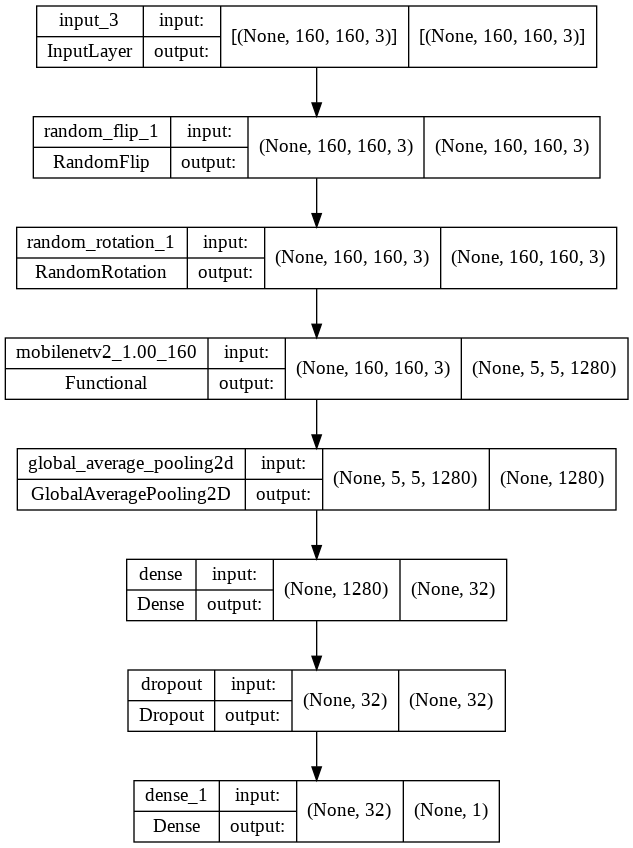

In [34]:
tf.keras.utils.plot_model(transferLearn_model, 'transferLearn_model.png', show_shapes = True)

**Lets set all layers of our base model to be trainable first. Then we will set layers up till 100 as not trainable.**

In [35]:
base_model.trainable = True
fine_tune_at_layer = 100

i=0
for layer in base_model.layers[:fine_tune_at_layer]:
  layer.trainable = False
  # print(i, layer.name)
  # i += 1

In [36]:
transferLearn_model.compile(optimizer = RMSprop(learning_rate=learning_rate_fine), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [38]:
transferLearn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 160, 160, 3)      0         
 tation)                                                         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                           

**Train the model to fine tune it now**

In [39]:
history_transferLearn_fine = transferLearn_model.fit(images_train, labels_train, epochs = 20, initial_epoch = history_transferLearn.epoch[-1], batch_size=batch_size,
                        validation_data = (images_valid, labels_valid), callbacks = [reduce_lr_on_plateau_fine])

Epoch 10/20
19/19 [==============================] - 28s 1s/step - loss: 0.3088 - accuracy: 0.8600 - val_loss: 0.1613 - val_accuracy: 0.9500 - lr: 1.0000e-05
Epoch 11/20
19/19 [==============================] - 21s 1s/step - loss: 0.2817 - accuracy: 0.8767 - val_loss: 0.1392 - val_accuracy: 0.9567 - lr: 1.0000e-05
Epoch 12/20
19/19 [==============================] - 21s 1s/step - loss: 0.2411 - accuracy: 0.9100 - val_loss: 0.1388 - val_accuracy: 0.9533 - lr: 1.0000e-05
Epoch 13/20
19/19 [==============================] - 23s 1s/step - loss: 0.2326 - accuracy: 0.8867 - val_loss: 0.1608 - val_accuracy: 0.9333 - lr: 1.0000e-05
Epoch 14/20
19/19 [==============================] - 21s 1s/step - loss: 0.2320 - accuracy: 0.9033 - val_loss: 0.1240 - val_accuracy: 0.9567 - lr: 1.0000e-05
Epoch 15/20
19/19 [==============================] - 23s 1s/step - loss: 0.2000 - accuracy: 0.9217 - val_loss: 0.1315 - val_accuracy: 0.9467 - lr: 1.0000e-05
Epoch 16/20
19/19 [==============================] -

**Plot the accuracy and loss chart**

<function matplotlib.pyplot.show>

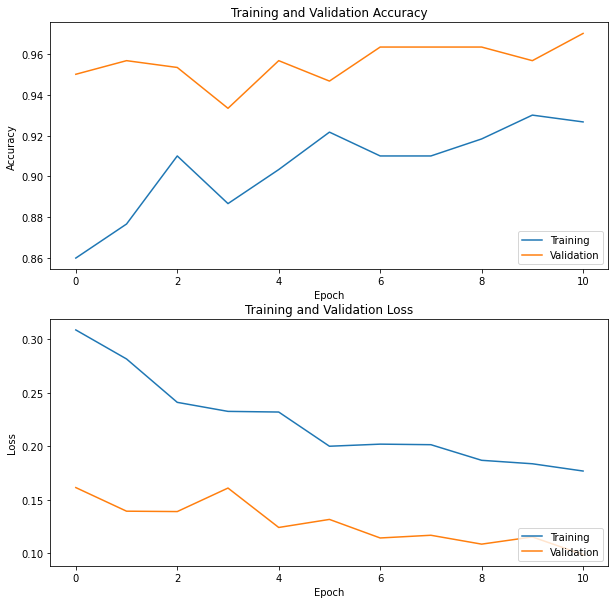

In [40]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(history_transferLearn_fine.history['accuracy'])
plt.plot(history_transferLearn_fine.history['val_accuracy'])
plt.legend(['Training', 'Validation'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(history_transferLearn_fine.history['loss'])
plt.plot(history_transferLearn_fine.history['val_loss'])
plt.legend(['Training', 'Validation'],loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show

**Evaluate the fine tuned model**

In [41]:
transferLearn_fine_test_loss, transferLearn_fine_test_acc = transferLearn_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(transferLearn_fine_test_loss))
print("Test accuracy: {}".format(transferLearn_fine_test_acc))

Test loss: 0.0743359923362732
Test accuracy: 0.9833333492279053


### Compare the customized transfer learn  model vs our fine tuned model

Plot the confusion matrices and the performance matrices for both models. We see that the customized fined tuned model is doing slightly better in comparison

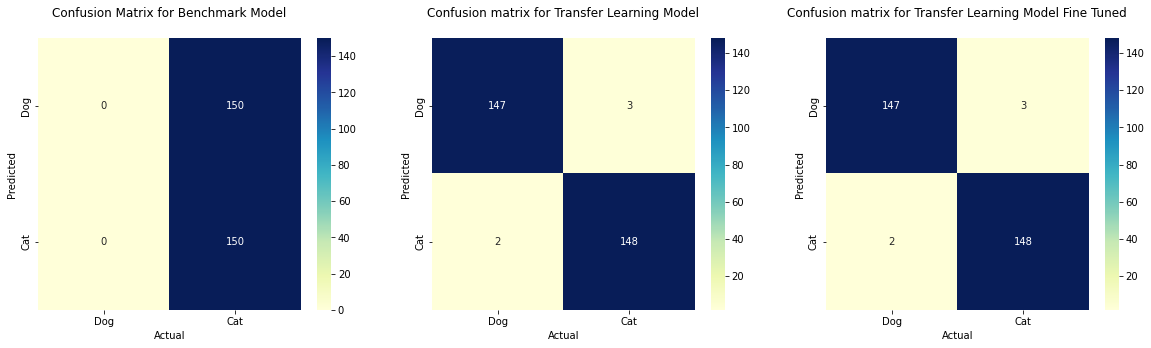

In [42]:
plt.figure(figsize = (20,5))

predictions_bnch = benchmark_model.predict(images_test)
predictions_bnch = (predictions_bnch >= 0.5).astype(np.int32)

confusion_mtx_bnch = confusion_matrix(labels_test, predictions_bnch)
df_confusion_mtx_bnch = pd.DataFrame(confusion_mtx_bnch, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])

plt.subplot(131)
plt.title("Confusion Matrix for Benchmark Model\n")
sns.heatmap(df_confusion_mtx_bnch, annot=True, fmt = 'd', cmap = 'YlGnBu')
plt.ylabel("Predicted")
plt.xlabel('Actual')

predictions = transferLearn_model.predict(images_test)
predictions = (predictions >= 0.5).astype(np.int32)

confusion_mtx = confusion_matrix(labels_test, predictions)
df_confusion_mtx = pd.DataFrame(confusion_mtx, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])

plt.subplot(132)
plt.title("Confusion matrix for Transfer Learning Model\n")
sns.heatmap(df_confusion_mtx, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")


predictions_fine = transferLearn_model.predict(images_test)
predictions_fine = (predictions_fine >= 0.5).astype(np.int32)

confusion_mtx_fine = confusion_matrix(labels_test, predictions_fine)
df_confusion_mtx_fine = pd.DataFrame(confusion_mtx_fine, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])

plt.subplot(133)
plt.title("Confusion matrix for Transfer Learning Model Fine Tuned\n")
sns.heatmap(df_confusion_mtx_fine, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")


plt.show()


In [43]:
transferLearn_model_fine_train_loss = history_transferLearn_fine.history['loss'][-1]
transferLearn_model_fine_valid_loss = history_transferLearn_fine.history['val_loss'][-1]
transferLearn_model_fine_train_acc = history_transferLearn_fine.history['accuracy'][-1]
transferLearn_model_fine_valid_acc = history_transferLearn_fine.history['val_accuracy'][-1]

metrics_fine_comparison_table = pd.DataFrame([['Training loss',transferLearn_model_train_loss , transferLearn_model_fine_train_loss],
                                ['Training accuracy', transferLearn_model_train_acc, transferLearn_model_fine_train_acc],
                                ['Validation loss', transferLearn_model_valid_loss, transferLearn_model_fine_valid_loss],
                                ['Validation accuracy', transferLearn_model_valid_acc, transferLearn_model_fine_valid_acc],
                                ['Test loss', transferLearn_test_loss, transferLearn_fine_test_loss ],
                                ['Test accuracy', transferLearn_test_acc, transferLearn_fine_test_acc]],
                               columns=['Metric', 'Tranfer Learn CNN', 'Transfer Fine Tuned CNN'])
metrics_fine_comparison_table



,Metric,Tranfer Learn CNN,Transfer Fine Tuned CNN
0,Training loss,0.323391,0.176781
1,Training accuracy,0.848333,0.926667
2,Validation loss,0.173769,0.098590
3,Validation accuracy,0.950000,0.970000
4,Test loss,0.157490,0.074336
5,Test accuracy,0.956667,0.983333
